# **Exploring small molecule senolytics through advanced graph neural network**

## **Installing Libraries**

In [ ]:
pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 19.7 MB/s eta 0:00:00


In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

## **Loading the data**

In [ ]:

# Loading the train data
train_data = pd.read_csv('train.csv')


In [ ]:
train_data

,SMILES,SENOLYTIC
0,CC(N)O.Cc1cc(CC(C)CC(C)(C)C)n(O)c(=O)c1,1
1,CC1CCC2C(C)C(O)OC3OC4(C)CCC1C32OO4,1
2,CCC(C)C1OC2(C=CC1C)CC1CC(CC=C(C)C(OC3CC(OC)C(...,1
3,COc1c(O)cc2oc3cc(O)c(CC=C(C)C)c(O)c3c(=O)c2c1...,1
4,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc...,1
...,...,...
2347,C1=CC(=C(C=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O)O,0
2348,C1C(=CC2=CC=CC=C2F)C(=O)C(=CC3=CC=CC=C3F)CN1.Cl,0
2349,COC1=CC(=CC(=C1OC)OC)C=CC(=O)N2CCC=CC2=O,0
2350,C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O,0


In [ ]:
print(type(train_data.loc[0, 'SENOLYTIC']))
print(type(train_data.loc[0, 'SMILES']))

<class 'numpy.int64'>
<class 'str'>


## **Feature Engineering**

In [ ]:
# Convert SMILES to RDKit molecules
train_data['Molecule'] = train_data['SMILES'].apply(Chem.MolFromSmiles)

In [ ]:
def smiles_to_molecule(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol, randomSeed=42)
        return mol
    else:
        return None

In [ ]:
from rdkit import RDLogger

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
train_data['Molecule'] = train_data['SMILES'].apply(smiles_to_molecule)

## **Molecular Visualization:**

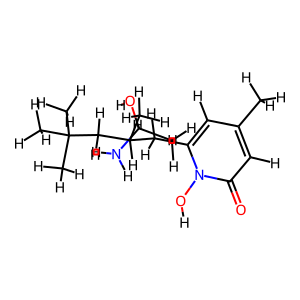

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

molecule = train_data['Molecule'].iloc[0]
Chem.Draw.MolToImage(molecule)

## **Handling Invalid SMILES**

In [ ]:
invalid_molecules = train_data[train_data['Molecule'].isnull()]
train_data = train_data.dropna()

In [ ]:
train_data

,SMILES,SENOLYTIC,Molecule
0,CC(N)O.Cc1cc(CC(C)CC(C)(C)C)n(O)c(=O)c1,1,<rdkit.Chem.rdchem.Mol object at 0x7b3776da2f80>
1,CC1CCC2C(C)C(O)OC3OC4(C)CCC1C32OO4,1,<rdkit.Chem.rdchem.Mol object at 0x7b3776da3220>
2,CCC(C)C1OC2(C=CC1C)CC1CC(CC=C(C)C(OC3CC(OC)C(...,1,<rdkit.Chem.rdchem.Mol object at 0x7b3776da2f10>
3,COc1c(O)cc2oc3cc(O)c(CC=C(C)C)c(O)c3c(=O)c2c1...,1,<rdkit.Chem.rdchem.Mol object at 0x7b3776da31b0>
4,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc...,1,<rdkit.Chem.rdchem.Mol object at 0x7b3776da3140>
...,...,...,...
2347,C1=CC(=C(C=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O)O,0,<rdkit.Chem.rdchem.Mol object at 0x7b377582bd80>
2348,C1C(=CC2=CC=CC=C2F)C(=O)C(=CC3=CC=CC=C3F)CN1.Cl,0,<rdkit.Chem.rdchem.Mol object at 0x7b377582bdf0>
2349,COC1=CC(=CC(=C1OC)OC)C=CC(=O)N2CCC=CC2=O,0,<rdkit.Chem.rdchem.Mol object at 0x7b377582be60>
2350,C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O,0,<rdkit.Chem.rdchem.Mol object at 0x7b377582bed0>


### **creating the 'edge_index' and 'edge_attr' columns for molecules.**

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

# Function to generate edge_index and edge_attr for a molecule
def generate_edge_information(molecule):
    if molecule is not None and molecule.GetNumAtoms() > 0:
        num_atoms = molecule.GetNumAtoms()
        edge_index = []  # List to store edge connections
        edge_attr = []   # List to store edge attributes (e.g., bond types)

        for bond in molecule.GetBonds():
            start_idx = bond.GetBeginAtomIdx()
            end_idx = bond.GetEndAtomIdx()
            bond_type = bond.GetBondTypeAsDouble()  # You can customize this part based on your needs

            # Add edge connection
            edge_index.append((start_idx, end_idx))
            edge_attr.append(bond_type)

        return edge_index, edge_attr
    return None, None

# Apply the function to each row in the DataFrame
train_data[['edge_index', 'edge_attr']] = train_data['Molecule'].apply(generate_edge_information).apply(pd.Series)

# Now, your 'train_data' DataFrame contains 'edge_index' and 'edge_attr' columns.


In [ ]:
train_data

,SMILES,SENOLYTIC,Molecule,edge_index,edge_attr
0,CC(N)O.Cc1cc(CC(C)CC(C)(C)C)n(O)c(=O)c1,1,<rdkit.Chem.rdchem.Mol object at 0x78f8bc1dd540>,"[(0, 1), (1, 2), (1, 3), (4, 5), (5, 6), (6, 7...","[1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.0, 1.0, ..."
1,CC1CCC2C(C)C(O)OC3OC4(C)CCC1C32OO4,1,<rdkit.Chem.rdchem.Mol object at 0x78f8bc1dd5b0>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,CCC(C)C1OC2(C=CC1C)CC1CC(CC=C(C)C(OC3CC(OC)C(...,1,<rdkit.Chem.rdchem.Mol object at 0x78f8bc1dd620>,"[(0, 1), (1, 2), (2, 3), (2, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, ..."
3,COc1c(O)cc2oc3cc(O)c(CC=C(C)C)c(O)c3c(=O)c2c1...,1,<rdkit.Chem.rdchem.Mol object at 0x78f8bc1dd690>,"[(0, 1), (1, 2), (2, 3), (3, 4), (3, 5), (5, 6...","[1.0, 1.0, 1.5, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, ..."
4,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc...,1,<rdkit.Chem.rdchem.Mol object at 0x78f8bc1dd700>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 1.0, 1.0, ..."
...,...,...,...,...,...
2347,C1=CC(=C(C=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O)O,0,<rdkit.Chem.rdchem.Mol object at 0x78f8bc046110>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 2.0, ..."
2348,C1C(=CC2=CC=CC=C2F)C(=O)C(=CC3=CC=CC=C3F)CN1.Cl,0,<rdkit.Chem.rdchem.Mol object at 0x78f8bc046180>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 2.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, ..."
2349,COC1=CC(=CC(=C1OC)OC)C=CC(=O)N2CCC=CC2=O,0,<rdkit.Chem.rdchem.Mol object at 0x78f8bc0461f0>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.0, ..."
2350,C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O,0,<rdkit.Chem.rdchem.Mol object at 0x78f8bc046260>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 2.0, ..."


### **Creating Graphs**

In [ ]:
from torch_geometric.data import Data
import torch

# Assuming your DataFrame is named df

# Define a function to convert row data to PyTorch Geometric Data object
def row_to_graph(row):
    x = row['Molecule']  # Assuming 'Molecule' column contains the RDKit molecule objects
    edge_index = torch.tensor(row['edge_index'], dtype=torch.long)
    edge_attr = torch.tensor(row['edge_attr'], dtype=torch.float)

    # You may need to convert other features to tensors and add them to x if necessary

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=row['SENOLYTIC'])

# Create the "Graph" column
train_data['Graph'] = train_data.apply(row_to_graph, axis=1)


In [ ]:
train_data

,SMILES,SENOLYTIC,Molecule,edge_index,edge_attr,Graph
0,CC(N)O.Cc1cc(CC(C)CC(C)(C)C)n(O)c(=O)c1,1,<rdkit.Chem.rdchem.Mol object at 0x7b3776da2f80>,"[(0, 1), (1, 2), (1, 3), (4, 5), (5, 6), (6, 7...","[1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b3776..."
1,CC1CCC2C(C)C(O)OC3OC4(C)CCC1C32OO4,1,<rdkit.Chem.rdchem.Mol object at 0x7b3776da3220>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b3776..."
2,CCC(C)C1OC2(C=CC1C)CC1CC(CC=C(C)C(OC3CC(OC)C(...,1,<rdkit.Chem.rdchem.Mol object at 0x7b3776da2f10>,"[(0, 1), (1, 2), (2, 3), (2, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b3776..."
3,COc1c(O)cc2oc3cc(O)c(CC=C(C)C)c(O)c3c(=O)c2c1...,1,<rdkit.Chem.rdchem.Mol object at 0x7b3776da31b0>,"[(0, 1), (1, 2), (2, 3), (3, 4), (3, 5), (5, 6...","[1.0, 1.0, 1.5, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b3776..."
4,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc...,1,<rdkit.Chem.rdchem.Mol object at 0x7b3776da3140>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b3776..."
...,...,...,...,...,...,...
2347,C1=CC(=C(C=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O)O,0,<rdkit.Chem.rdchem.Mol object at 0x7b377582bd80>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 2.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b3775..."
2348,C1C(=CC2=CC=CC=C2F)C(=O)C(=CC3=CC=CC=C3F)CN1.Cl,0,<rdkit.Chem.rdchem.Mol object at 0x7b377582bdf0>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 2.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b3775..."
2349,COC1=CC(=CC(=C1OC)OC)C=CC(=O)N2CCC=CC2=O,0,<rdkit.Chem.rdchem.Mol object at 0x7b377582be60>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b3775..."
2350,C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O,0,<rdkit.Chem.rdchem.Mol object at 0x7b377582bed0>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 2.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b3775..."


## **Creating Node Features (x)**

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors

def calculate_molecular_weight(molecule):
    if molecule is not None:
        mw = Descriptors.MolWt(molecule)
        return mw
    return None

train_data['MolecularWeight'] = train_data['Molecule'].apply(calculate_molecular_weight)



In [ ]:
train_data

,SMILES,SENOLYTIC,Molecule,edge_index,edge_attr,Graph,MolecularWeight
0,CC(N)O.Cc1cc(CC(C)CC(C)(C)C)n(O)c(=O)c1,1,<rdkit.Chem.rdchem.Mol object at 0x78f95ba21620>,"[(0, 1), (1, 2), (1, 3), (4, 5), (5, 6), (6, 7...","[1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",298.427
1,CC1CCC2C(C)C(O)OC3OC4(C)CCC1C32OO4,1,<rdkit.Chem.rdchem.Mol object at 0x78f95ba21150>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",284.352
2,CCC(C)C1OC2(C=CC1C)CC1CC(CC=C(C)C(OC3CC(OC)C(...,1,<rdkit.Chem.rdchem.Mol object at 0x78f95ba212a0>,"[(0, 1), (1, 2), (2, 3), (2, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",873.090
3,COc1c(O)cc2oc3cc(O)c(CC=C(C)C)c(O)c3c(=O)c2c1...,1,<rdkit.Chem.rdchem.Mol object at 0x78f95ba210e0>,"[(0, 1), (1, 2), (2, 3), (3, 4), (3, 5), (5, 6...","[1.0, 1.0, 1.5, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",410.466
4,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc...,1,<rdkit.Chem.rdchem.Mol object at 0x78f95ba21000>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",381.379
...,...,...,...,...,...,...,...
2347,C1=CC(=C(C=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O)O,0,<rdkit.Chem.rdchem.Mol object at 0x78f95b879d90>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 2.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",286.239
2348,C1C(=CC2=CC=CC=C2F)C(=O)C(=CC3=CC=CC=C3F)CN1.Cl,0,<rdkit.Chem.rdchem.Mol object at 0x78f95b879e00>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 2.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",347.792
2349,COC1=CC(=CC(=C1OC)OC)C=CC(=O)N2CCC=CC2=O,0,<rdkit.Chem.rdchem.Mol object at 0x78f95b879e70>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",317.341
2350,C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O,0,<rdkit.Chem.rdchem.Mol object at 0x78f95b879ee0>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 2.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",302.238


In [ ]:
# Chemical Descriptors
train_data['NumHBA'] = train_data['Molecule'].apply(lambda mol: Descriptors.NumHAcceptors(mol) if mol is not None else None)
train_data['NumHBD'] = train_data['Molecule'].apply(lambda mol: Descriptors.NumHDonors(mol) if mol is not None else None)
train_data['LogP'] = train_data['Molecule'].apply(lambda mol: Descriptors.MolLogP(mol) if mol is not None else None)

In [ ]:
train_data

,SMILES,SENOLYTIC,Molecule,edge_index,edge_attr,Graph,MolecularWeight,NumHBA,NumHBD,LogP
0,CC(N)O.Cc1cc(CC(C)CC(C)(C)C)n(O)c(=O)c1,1,<rdkit.Chem.rdchem.Mol object at 0x7b9a8c599f50>,"[(0, 1), (1, 2), (1, 3), (4, 5), (5, 6), (6, 7...","[1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b9a8c...",298.427,5,3,2.29222
1,CC1CCC2C(C)C(O)OC3OC4(C)CCC1C32OO4,1,<rdkit.Chem.rdchem.Mol object at 0x7b9a8c599fc0>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b9a8c...",284.352,5,1,2.18670
2,CCC(C)C1OC2(C=CC1C)CC1CC(CC=C(C)C(OC3CC(OC)C(...,1,<rdkit.Chem.rdchem.Mol object at 0x7b9a8c59a030>,"[(0, 1), (1, 2), (2, 3), (2, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b9a8c...",873.090,14,3,5.37740
3,COc1c(O)cc2oc3cc(O)c(CC=C(C)C)c(O)c3c(=O)c2c1...,1,<rdkit.Chem.rdchem.Mol object at 0x7b9a8c59a0a0>,"[(0, 1), (1, 2), (2, 3), (3, 4), (3, 5), (5, 6...","[1.0, 1.0, 1.5, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b9a8c...",410.466,6,3,5.08900
4,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc...,1,<rdkit.Chem.rdchem.Mol object at 0x7b9a8c59a110>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b9a8c...",381.379,4,1,3.51392
...,...,...,...,...,...,...,...,...,...,...
2347,C1=CC(=C(C=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O)O,0,<rdkit.Chem.rdchem.Mol object at 0x7b9a8c5deb20>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 2.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b9a8c...",286.239,6,4,2.28240
2348,C1C(=CC2=CC=CC=C2F)C(=O)C(=CC3=CC=CC=C3F)CN1.Cl,0,<rdkit.Chem.rdchem.Mol object at 0x7b9a8c5deb90>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 2.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b9a8c...",347.792,2,1,4.02590
2349,COC1=CC(=CC(=C1OC)OC)C=CC(=O)N2CCC=CC2=O,0,<rdkit.Chem.rdchem.Mol object at 0x7b9a8c5dec00>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b9a8c...",317.341,5,0,2.04070
2350,C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O,0,<rdkit.Chem.rdchem.Mol object at 0x7b9a8c5dec70>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 2.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b9a8c...",302.238,7,5,1.98800


In [ ]:
# Define a function to check the presence of specific functional groups
def has_functional_group(mol, functional_group):
    if mol is not None:
        return mol.HasSubstructMatch(Chem.MolFromSmiles(functional_group))
    return None

# Example: Check for the presence of a hydroxyl group
train_data['HasHydroxylGroup'] = train_data['Molecule'].apply(lambda mol: has_functional_group(mol, 'O'))


In [ ]:
train_data

,SMILES,SENOLYTIC,Molecule,edge_index,edge_attr,Graph,MolecularWeight,NumHBA,NumHBD,LogP,HasHydroxylGroup
0,CC(N)O.Cc1cc(CC(C)CC(C)(C)C)n(O)c(=O)c1,1,<rdkit.Chem.rdchem.Mol object at 0x78f95ba21620>,"[(0, 1), (1, 2), (1, 3), (4, 5), (5, 6), (6, 7...","[1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",298.427,5,3,2.29222,True
1,CC1CCC2C(C)C(O)OC3OC4(C)CCC1C32OO4,1,<rdkit.Chem.rdchem.Mol object at 0x78f95ba21150>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",284.352,5,1,2.18670,True
2,CCC(C)C1OC2(C=CC1C)CC1CC(CC=C(C)C(OC3CC(OC)C(...,1,<rdkit.Chem.rdchem.Mol object at 0x78f95ba212a0>,"[(0, 1), (1, 2), (2, 3), (2, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",873.090,14,3,5.37740,True
3,COc1c(O)cc2oc3cc(O)c(CC=C(C)C)c(O)c3c(=O)c2c1...,1,<rdkit.Chem.rdchem.Mol object at 0x78f95ba210e0>,"[(0, 1), (1, 2), (2, 3), (3, 4), (3, 5), (5, 6...","[1.0, 1.0, 1.5, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",410.466,6,3,5.08900,True
4,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc...,1,<rdkit.Chem.rdchem.Mol object at 0x78f95ba21000>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",381.379,4,1,3.51392,True
...,...,...,...,...,...,...,...,...,...,...,...
2347,C1=CC(=C(C=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O)O,0,<rdkit.Chem.rdchem.Mol object at 0x78f95b879d90>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 2.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",286.239,6,4,2.28240,True
2348,C1C(=CC2=CC=CC=C2F)C(=O)C(=CC3=CC=CC=C3F)CN1.Cl,0,<rdkit.Chem.rdchem.Mol object at 0x78f95b879e00>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 2.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",347.792,2,1,4.02590,True
2349,COC1=CC(=CC(=C1OC)OC)C=CC(=O)N2CCC=CC2=O,0,<rdkit.Chem.rdchem.Mol object at 0x78f95b879e70>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",317.341,5,0,2.04070,True
2350,C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O,0,<rdkit.Chem.rdchem.Mol object at 0x78f95b879ee0>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 2.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",302.238,7,5,1.98800,True


In [ ]:
from rdkit.Chem import Descriptors

# Example: Adding molecular descriptors
def calculate_molecular_descriptors(molecule):
    if molecule is not None:
        # Example descriptors

        num_rotatable_bonds = Descriptors.NumRotatableBonds(molecule)
        num_heavy_atoms = Descriptors.HeavyAtomCount(molecule)

        return  num_rotatable_bonds, num_heavy_atoms

    return None, None, None

# Apply the function to each row in the DataFrame
train_data[[ 'NumRotatableBonds', 'NumHeavyAtoms']] = train_data['Molecule'].apply(calculate_molecular_descriptors).apply(pd.Series)


In [ ]:
train_data

,SMILES,SENOLYTIC,Molecule,edge_index,edge_attr,Graph,MolecularWeight,NumHBA,NumHBD,LogP,HasHydroxylGroup,NumRotatableBonds,NumHeavyAtoms
0,CC(N)O.Cc1cc(CC(C)CC(C)(C)C)n(O)c(=O)c1,1,<rdkit.Chem.rdchem.Mol object at 0x78f95ba21620>,"[(0, 1), (1, 2), (1, 3), (4, 5), (5, 6), (6, 7...","[1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",298.427,5,3,2.29222,True,3,21
1,CC1CCC2C(C)C(O)OC3OC4(C)CCC1C32OO4,1,<rdkit.Chem.rdchem.Mol object at 0x78f95ba21150>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",284.352,5,1,2.18670,True,0,20
2,CCC(C)C1OC2(C=CC1C)CC1CC(CC=C(C)C(OC3CC(OC)C(...,1,<rdkit.Chem.rdchem.Mol object at 0x78f95ba212a0>,"[(0, 1), (1, 2), (2, 3), (2, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",873.090,14,3,5.37740,True,8,62
3,COc1c(O)cc2oc3cc(O)c(CC=C(C)C)c(O)c3c(=O)c2c1...,1,<rdkit.Chem.rdchem.Mol object at 0x78f95ba210e0>,"[(0, 1), (1, 2), (2, 3), (3, 4), (3, 5), (5, 6...","[1.0, 1.0, 1.5, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",410.466,6,3,5.08900,True,5,30
4,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc...,1,<rdkit.Chem.rdchem.Mol object at 0x78f95ba21000>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",381.379,4,1,3.51392,True,3,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347,C1=CC(=C(C=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O)O,0,<rdkit.Chem.rdchem.Mol object at 0x78f95b879d90>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 2.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",286.239,6,4,2.28240,True,1,21
2348,C1C(=CC2=CC=CC=C2F)C(=O)C(=CC3=CC=CC=C3F)CN1.Cl,0,<rdkit.Chem.rdchem.Mol object at 0x78f95b879e00>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 2.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",347.792,2,1,4.02590,True,2,24
2349,COC1=CC(=CC(=C1OC)OC)C=CC(=O)N2CCC=CC2=O,0,<rdkit.Chem.rdchem.Mol object at 0x78f95b879e70>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",317.341,5,0,2.04070,True,5,23
2350,C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O,0,<rdkit.Chem.rdchem.Mol object at 0x78f95b879ee0>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 2.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",302.238,7,5,1.98800,True,1,22


In [ ]:
import networkx as nx
from rdkit.Chem import Descriptors

# Example: Adding graph-based descriptors
def calculate_graph_descriptors(edge_index):
    if edge_index is not None:
        # Convert edge_index to a NetworkX graph
        G = nx.Graph(edge_index)

        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        graph_density = nx.density(G)
        is_connected = nx.is_connected(G)

        # Additional descriptors
        wiener_index = nx.wiener_index(G)


        return num_nodes, num_edges, graph_density, is_connected, wiener_index

    return None, None, None, None, None, None

# Apply the function to each row in the DataFrame
train_data[['NumNodes', 'NumEdges', 'GraphDensity', 'IsConnected', 'WienerIndex']] = train_data['edge_index'].apply(calculate_graph_descriptors).apply(pd.Series)


In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors

# Example: Adding graph-based descriptors
def calculate_graph_descriptors(molecule):
    if molecule is not None:
        # Calculate BalabanJ for the RDKit molecule
        balaban_index = Descriptors.BalabanJ(molecule)

        return balaban_index

    return None

# Apply the function to each row in the DataFrame
train_data['BalabanIndex'] = train_data['Molecule'].apply(calculate_graph_descriptors)


In [ ]:
train_data

,SMILES,SENOLYTIC,Molecule,edge_index,edge_attr,Graph,MolecularWeight,NumHBA,NumHBD,LogP,HasHydroxylGroup,NumRotatableBonds,NumHeavyAtoms,NumNodes,NumEdges,GraphDensity,IsConnected,WienerIndex,BalabanIndex
0,CC(N)O.Cc1cc(CC(C)CC(C)(C)C)n(O)c(=O)c1,1,<rdkit.Chem.rdchem.Mol object at 0x78f95ba21620>,"[(0, 1), (1, 2), (1, 3), (4, 5), (5, 6), (6, 7...","[1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",298.427,5,3,2.29222,True,3,21,21,20,0.095238,False,inf,8.852940e-07
1,CC1CCC2C(C)C(O)OC3OC4(C)CCC1C32OO4,1,<rdkit.Chem.rdchem.Mol object at 0x78f95ba21150>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",284.352,5,1,2.18670,True,0,20,20,23,0.121053,True,627.0,1.817282e+00
2,CCC(C)C1OC2(C=CC1C)CC1CC(CC=C(C)C(OC3CC(OC)C(...,1,<rdkit.Chem.rdchem.Mol object at 0x78f95ba212a0>,"[(0, 1), (1, 2), (2, 3), (2, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",873.090,14,3,5.37740,True,8,62,62,68,0.035960,True,17028.0,1.182608e+00
3,COc1c(O)cc2oc3cc(O)c(CC=C(C)C)c(O)c3c(=O)c2c1...,1,<rdkit.Chem.rdchem.Mol object at 0x78f95ba210e0>,"[(0, 1), (1, 2), (2, 3), (3, 4), (3, 5), (5, 6...","[1.0, 1.0, 1.5, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",410.466,6,3,5.08900,True,5,30,30,32,0.073563,True,2317.0,2.451078e+00
4,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc...,1,<rdkit.Chem.rdchem.Mol object at 0x78f95ba21000>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",381.379,4,1,3.51392,True,3,26,26,28,0.086154,True,1654.0,2.160670e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347,C1=CC(=C(C=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O)O,0,<rdkit.Chem.rdchem.Mol object at 0x78f95b879d90>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 2.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",286.239,6,4,2.28240,True,1,21,21,23,0.109524,True,896.0,2.294346e+00
2348,C1C(=CC2=CC=CC=C2F)C(=O)C(=CC3=CC=CC=C3F)CN1.Cl,0,<rdkit.Chem.rdchem.Mol object at 0x78f95b879e00>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 2.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",347.792,2,1,4.02590,True,2,24,23,25,0.098814,True,1246.0,2.083332e-06
2349,COC1=CC(=CC(=C1OC)OC)C=CC(=O)N2CCC=CC2=O,0,<rdkit.Chem.rdchem.Mol object at 0x78f95b879e70>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",317.341,5,0,2.04070,True,5,23,23,24,0.094862,True,1282.0,2.233418e+00
2350,C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O,0,<rdkit.Chem.rdchem.Mol object at 0x78f95b879ee0>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 2.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",302.238,7,5,1.98800,True,1,22,22,24,0.103896,True,986.0,2.377258e+00


In [ ]:
train_data.dtypes

SMILES                object
SENOLYTIC              int64
Molecule              object
edge_index            object
edge_attr             object
Graph                 object
MolecularWeight      float64
NumHBA                 int64
NumHBD                 int64
LogP                 float64
HasHydroxylGroup        bool
NumRotatableBonds      int64
NumHeavyAtoms          int64
NumNodes               int64
NumEdges               int64
GraphDensity         float64
IsConnected             bool
WienerIndex          float64
BalabanIndex         float64
dtype: object

In [ ]:
import pandas as pd
from sklearn import preprocessing
import numpy as np

# Assuming your DataFrame is named df
numerical_columns = train_data.select_dtypes(include=['float64', 'int64'])

# Replace infinity values with a large finite value
numerical_columns.replace([np.inf, -np.inf], 1e9, inplace=True)

# Now, you can perform any data transformation or normalization on the numerical columns
# For example, you can use Min-Max scaling to normalize the values to the range [0, 1]
min_max_scaler = preprocessing.MinMaxScaler()
numerical_columns_normalized = pd.DataFrame(min_max_scaler.fit_transform(numerical_columns), columns=numerical_columns.columns)

# Replace the original numerical columns with the normalized ones
train_data[numerical_columns.columns] = numerical_columns_normalized

In [ ]:
# Assuming your DataFrame is named 'df' and contains boolean columns
boolean_columns = ['IsConnected','HasHydroxylGroup']

# Convert boolean columns to numeric (0 and 1)
train_data[boolean_columns] = train_data[boolean_columns].astype(int)

# Now, the boolean columns are converted to numeric (0 and 1)


In [ ]:
train_data

,SMILES,SENOLYTIC,Molecule,edge_index,edge_attr,Graph,MolecularWeight,NumHBA,NumHBD,LogP,HasHydroxylGroup,NumRotatableBonds,NumHeavyAtoms,NumNodes,NumEdges,GraphDensity,IsConnected,WienerIndex,BalabanIndex
0,CC(N)O.Cc1cc(CC(C)CC(C)(C)C)n(O)c(=O)c1,1.0,<rdkit.Chem.rdchem.Mol object at 0x78f95ba21620>,"[(0, 1), (1, 2), (1, 3), (4, 5), (5, 6), (6, 7...","[1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.0, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",0.114874,0.066667,0.075,0.765891,1,0.056604,0.135338,0.135338,0.125874,0.122350,0,1.000000e+00,0.000001
1,CC1CCC2C(C)C(O)OC3OC4(C)CCC1C32OO4,1.0,<rdkit.Chem.rdchem.Mol object at 0x78f95ba21150>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",0.108091,0.066667,0.025,0.764303,1,0.000000,0.127820,0.127820,0.146853,0.161998,1,6.230000e-07,0.262988
2,CCC(C)C1OC2(C=CC1C)CC1CC(CC=C(C)C(OC3CC(OC)C(...,1.0,<rdkit.Chem.rdchem.Mol object at 0x78f95ba212a0>,"[(0, 1), (1, 2), (2, 3), (2, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",0.391811,0.186667,0.075,0.812304,1,0.150943,0.443609,0.443609,0.461538,0.031305,1,1.702400e-05,0.171142
3,COc1c(O)cc2oc3cc(O)c(CC=C(C)C)c(O)c3c(=O)c2c1...,1.0,<rdkit.Chem.rdchem.Mol object at 0x78f95ba210e0>,"[(0, 1), (1, 2), (2, 3), (3, 4), (3, 5), (5, 6...","[1.0, 1.0, 1.5, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",0.168867,0.080000,0.075,0.807965,1,0.094340,0.203008,0.203008,0.209790,0.089060,1,2.313000e-06,0.354708
4,Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc...,1.0,<rdkit.Chem.rdchem.Mol object at 0x78f95ba21000>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",0.154850,0.053333,0.025,0.784270,1,0.056604,0.172932,0.172932,0.181818,0.108398,1,1.650000e-06,0.312682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347,C1=CC(=C(C=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O)O,0.0,<rdkit.Chem.rdchem.Mol object at 0x78f95b879d90>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 2.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",0.109000,0.080000,0.100,0.765743,1,0.018868,0.135338,0.135338,0.146853,0.144291,1,8.920000e-07,0.332027
2348,C1C(=CC2=CC=CC=C2F)C(=O)C(=CC3=CC=CC=C3F)CN1.Cl,0.0,<rdkit.Chem.rdchem.Mol object at 0x78f95b879e00>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 2.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",0.138664,0.026667,0.025,0.791972,1,0.037736,0.157895,0.150376,0.160839,0.127843,1,1.242000e-06,0.000001
2349,COC1=CC(=CC(=C1OC)OC)C=CC(=O)N2CCC=CC2=O,0.0,<rdkit.Chem.rdchem.Mol object at 0x78f95b879e70>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",0.123989,0.066667,0.000,0.762107,1,0.094340,0.150376,0.150376,0.153846,0.121772,1,1.278000e-06,0.323209
2350,C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O,0.0,<rdkit.Chem.rdchem.Mol object at 0x78f95b879ee0>,"[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6...","[1.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 2.0, ...","[(x, <rdkit.Chem.rdchem.Mol object at 0x78f95b...",0.116711,0.093333,0.125,0.761314,1,0.018868,0.142857,0.142857,0.153846,0.135648,1,9.820000e-07,0.344025


## **Data Visualization**

**Class Distribution**

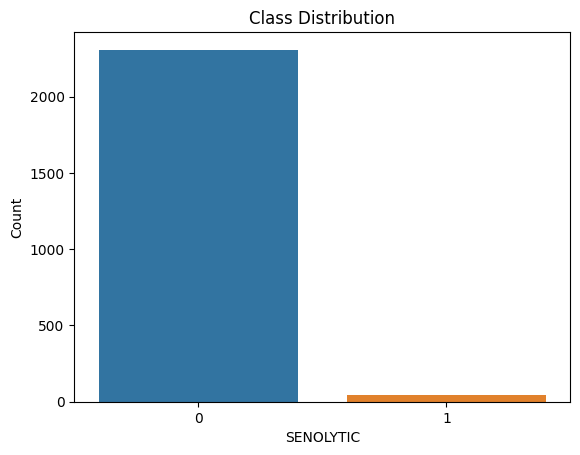

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#
sns.countplot(x='SENOLYTIC', data=train_data)
plt.xlabel('SENOLYTIC')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

**Molecular Weight Distribution**

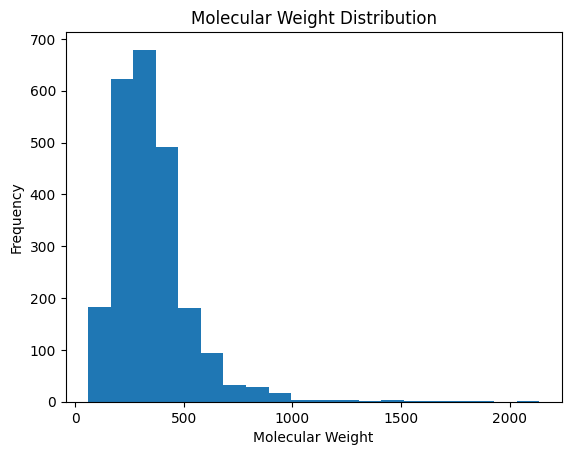

In [ ]:

plt.hist(train_data['MolecularWeight'], bins=20)
plt.xlabel('Molecular Weight')
plt.ylabel('Frequency')
plt.title('Molecular Weight Distribution')
plt.show()

## **Correlation Heatmap**

<ipython-input-285-88a02d999c69>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_data.corr()


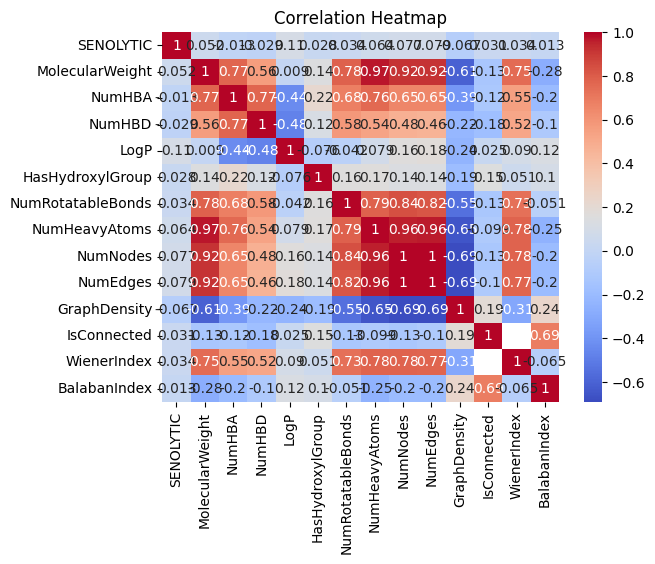

In [ ]:
correlation_matrix = train_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

**Graph Visualization**

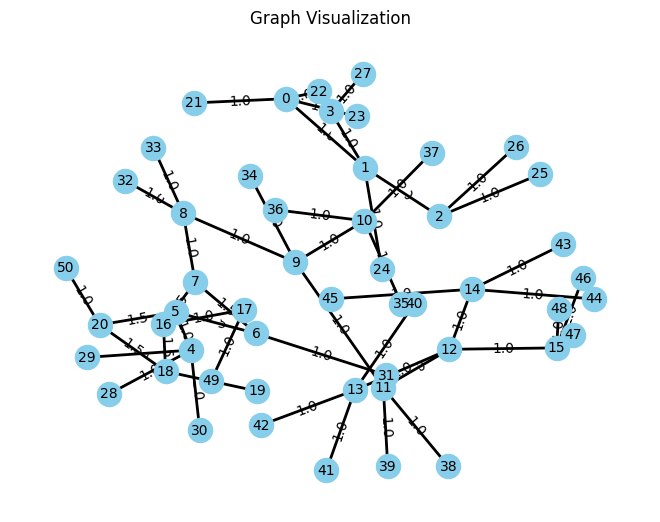

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(row):
    G = nx.Graph()

    # Extract edge information and add edges
    edge_index = row['edge_index']
    edge_attr = row['edge_attr']

    for edge, attr in zip(edge_index, edge_attr):
        src, tgt = edge
        G.add_edge(src, tgt, weight=attr)

    # Define the layout and customize node/edge parameters
    pos = nx.spring_layout(G, seed=42, k=0.5)  # Adjust 'k' for node separation
    labels = nx.get_edge_attributes(G, 'weight')

    # Customize the node size, node color, and edge width
    node_size = 300
    node_color = 'skyblue'
    edge_width = 2

    # Draw the graph with customization
    nx.draw(G, pos, with_labels=True, node_size=node_size, node_color=node_color, font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    edges = nx.draw_networkx_edges(G, pos, width=edge_width)

    # Show the graph
    plt.title("Graph Visualization")
    plt.show()

# Assuming you have the 'edge_index' and 'edge_attr' in your DataFrame
visualize_graph(train_data.iloc[0])


**Chemical Structure Visualization**

/usr/local/lib/python3.10/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


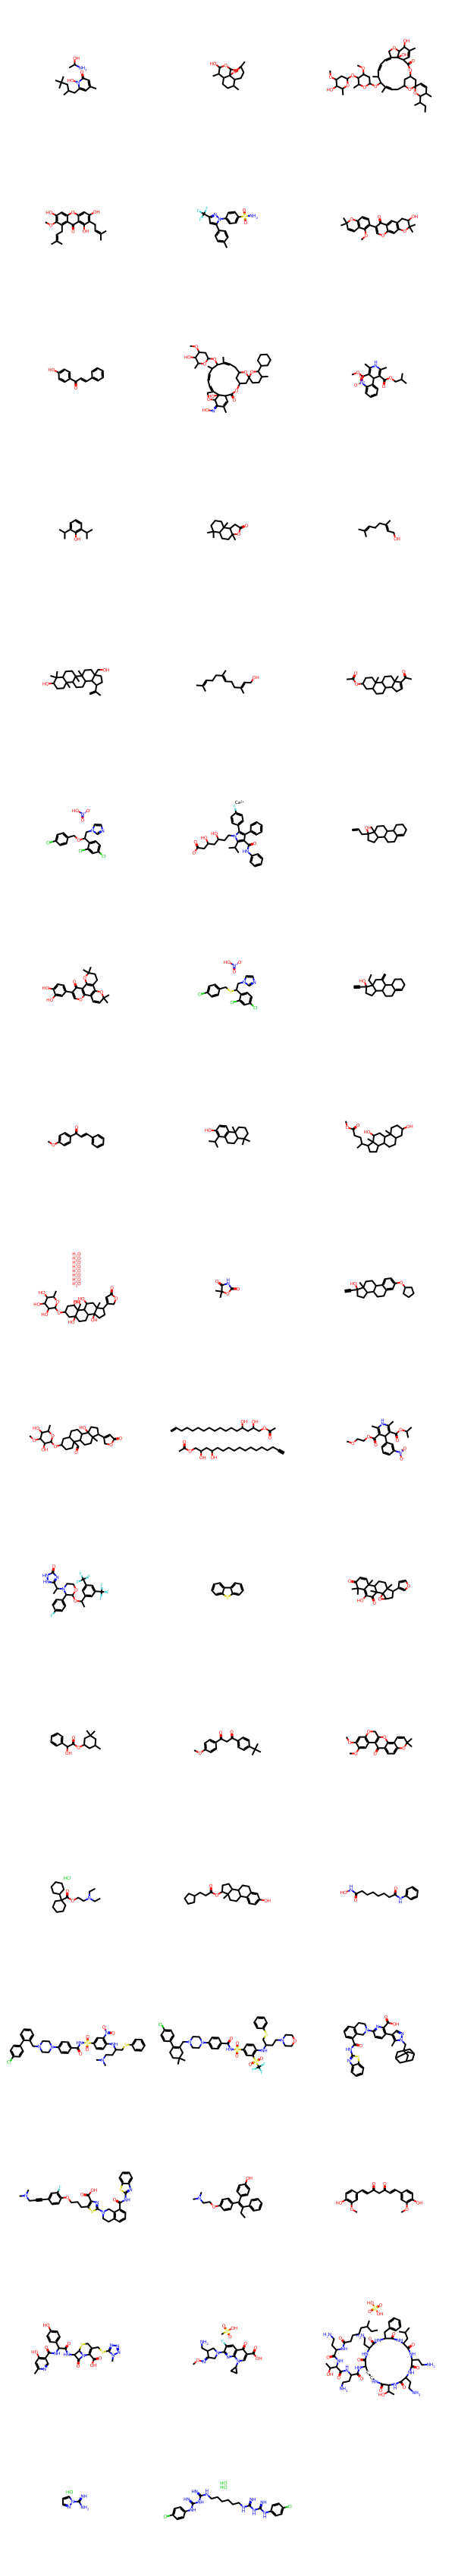

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
from IPython.display import display

# Replace 'df' with your DataFrame containing the SMILES strings
# The 'SMILES' column should contain your SMILES strings.
smiles_list = train_data['SMILES']

# Convert SMILES strings to RDKit Mol objects
mol_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

# Draw and visualize the chemical structures
img = Draw.MolsToGridImage(mol_list, molsPerRow=3, subImgSize=(200, 200))

# Display the image in Colab
display(img)



**Pair plot**

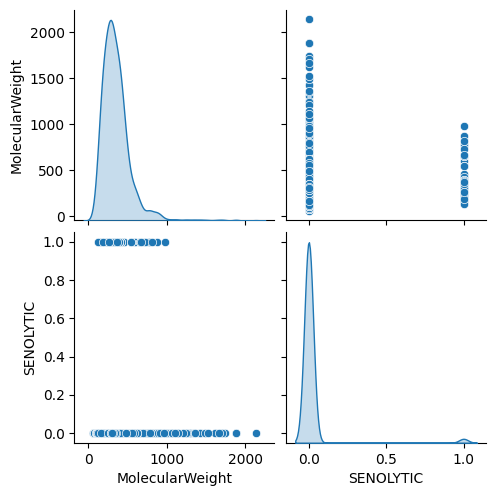

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Replace 'train_data' with the name of your DataFrame
# Specify the three columns you want to include in the pair plot
columns_to_include = ['MolecularWeight', 'SENOLYTIC', 'Graph']

# Create a pair plot
sns.pairplot(train_data[columns_to_include], diag_kind='kde')
plt.show()

## **Splitting the data**

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'train_data' is your DataFrame
train_set, test_set = train_test_split(train_data, test_size=200, random_state=42, stratify=train_data['SENOLYTIC'], shuffle=True)

# Print the shapes of the resulting sets
print("Training set shape:", train_set.shape)
print("Testing set shape:", test_set.shape)


Training set shape: (2152, 19)
Testing set shape: (200, 19)


In [ ]:
test_set

,SMILES,SENOLYTIC,Molecule,edge_index,edge_attr,Graph,MolecularWeight,NumHBA,NumHBD,LogP,HasHydroxylGroup,NumRotatableBonds,NumHeavyAtoms,NumNodes,NumEdges,GraphDensity,IsConnected,WienerIndex,BalabanIndex
905,CCC1(C2OC(C3OC(O)(CO)C(C)CC3C)CC2C)CCC(C2(C)C...,0.0,<rdkit.Chem.rdchem.Mol object at 0x7b99ca141a10>,"[[tensor(0), tensor(1), tensor(2), tensor(3), ...","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b99ca...",0.304958,0.146667,0.075,0.730537,1,0.188679,0.338346,0.330827,0.342657,0.048536,1,8.551000e-06,0.000002
2312,CC(C)n1c(C=CC(O)CC(O)CC(=O)[O-])c(-c2ccc(F)cc...,0.0,<rdkit.Chem.rdchem.Mol object at 0x7b99c9bd4190>,"[[tensor(0), tensor(1), tensor(1), tensor(3), ...","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b99c9...",0.179946,0.066667,0.050,0.735881,1,0.150943,0.210526,0.203008,0.209790,0.089060,1,2.472000e-06,0.000002
1540,COc1cc(C=O)cc(OC)c1OC,0.0,<rdkit.Chem.rdchem.Mol object at 0x7b99cc7114d0>,"[[tensor(0), tensor(1), tensor(2), tensor(3), ...","[tensor(1.), tensor(1.), tensor(1.5000), tenso...","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b99cc...",0.065610,0.053333,0.000,0.754347,1,0.075472,0.082707,0.082707,0.083916,0.212365,1,2.870000e-07,0.478903
1229,CCCNC(=O)NS(=O)(=O)c1ccc(Cl)cc1,0.0,<rdkit.Chem.rdchem.Mol object at 0x7b9a8af8aea0>,"[[tensor(0), tensor(1), tensor(2), tensor(3), ...","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b9a8a...",0.104425,0.040000,0.050,0.757552,1,0.075472,0.105263,0.105263,0.104895,0.168061,1,5.620000e-07,0.398017
1683,O=C1CN(N=Cc2ccc(-c3ccc([N+](=O)[O-])cc3)o2)C(...,0.0,<rdkit.Chem.rdchem.Mol object at 0x7b99c96e53f0>,"[[tensor(0), tensor(1), tensor(2), tensor(3), ...","[tensor(2.), tensor(1.), tensor(1.), tensor(1....","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b99c9...",0.133096,0.080000,0.000,0.724315,1,0.075472,0.157895,0.150376,0.160839,0.127843,1,1.392000e-06,0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086,CC(=O)SC1CC2=CC(=O)CCC2(C)C2CCC3(C)C(CCC34CCC...,0.0,<rdkit.Chem.rdchem.Mol object at 0x7b99c9fc5d90>,"[[tensor(0), tensor(1), tensor(1), tensor(3), ...","[tensor(1.), tensor(2.), tensor(1.), tensor(1....","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b99c9...",0.171815,0.066667,0.000,0.804405,1,0.018868,0.195489,0.195489,0.216783,0.100913,1,1.901000e-06,0.225354
1484,COc1ccc(C(=O)O)c(O)c1OC,0.0,<rdkit.Chem.rdchem.Mol object at 0x7b99cc7a5c40>,"[[tensor(0), tensor(1), tensor(2), tensor(3), ...","[tensor(1.), tensor(1.), tensor(1.5000), tenso...","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b99cc...",0.066561,0.053333,0.050,0.748069,1,0.056604,0.082707,0.082707,0.083916,0.212365,1,2.840000e-07,0.483827
2000,CC(=O)c1c(O)c(C)c(O)c2c1OC1=CC(=O)C(C(C)=O)C(...,0.0,<rdkit.Chem.rdchem.Mol object at 0x7b99c9d7b760>,"[[tensor(0), tensor(1), tensor(1), tensor(3), ...","[tensor(1.), tensor(2.), tensor(1.), tensor(1....","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b99c9...",0.136990,0.093333,0.050,0.753970,1,0.037736,0.165414,0.165414,0.174825,0.114305,1,1.232000e-06,0.349248
1083,CC(C)(Oc1ccc(Cl)cc1)C(=O)O,0.0,<rdkit.Chem.rdchem.Mol object at 0x7b9a8b328580>,"[[tensor(0), tensor(1), tensor(1), tensor(3), ...","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[(x, <rdkit.Chem.rdchem.Mol object at 0x7b9a8b...",0.074500,0.026667,0.025,0.770250,1,0.056604,0.082707,0.082707,0.083916,0.212365,1,3.110000e-07,0.403242


In [ ]:
# Assuming 'SENOLYTIC' is the column containing class labels
class_counts = test_set['SENOLYTIC'].value_counts()

print("Count of class 0 in test_set:", class_counts[0])
print("Count of class 1 in test_set:", class_counts[1])


Count of class 0 in test_set: 232
Count of class 1 in test_set: 4


## **Preprocessing the  Train data and Creating the Pytorch Object**

In [ ]:
import torch
import pandas as pd

# Assuming 'edge_index' and 'edge_attr' are lists in your DataFrame
train_set['edge_index'] = train_set['edge_index'].apply(lambda x: torch.tensor(x).t().contiguous())
train_set['edge_attr'] = train_set['edge_attr'].apply(lambda x: torch.tensor(x, dtype=torch.float))

# Assuming node features are PyTorch tensors
node_features = torch.tensor(train_set[['MolecularWeight', 'NumHBA', 'NumHBD', 'LogP']].to_numpy(), dtype=torch.float)

# Assuming SENOLYTIC is your target variable
target = torch.tensor(train_set['SENOLYTIC'].to_numpy(), dtype=torch.long)

# Create a PyTorch Geometric Data object
data = list(zip(train_set['edge_index'], train_set['edge_attr']))
data = [(x[0].t().contiguous(), x[1]) for x in data]
data = Data(x=node_features, edge_index=data[0][0], edge_attr=data[0][1], y=target)


## **Preprocessing the Test data and Creating the Pytorch Object**

In [ ]:
import torch
import pandas as pd

# Assuming 'edge_index' and 'edge_attr' are lists in your DataFrame
test_set['edge_index'] = test_set['edge_index'].apply(lambda x: torch.tensor(x).t().contiguous())
test_set['edge_attr'] = test_set['edge_attr'].apply(lambda x: torch.tensor(x, dtype=torch.float))


# Assuming node features are PyTorch tensors
test_node_features = torch.tensor(test_set[['MolecularWeight', 'NumHBA', 'NumHBD', 'LogP']].to_numpy(), dtype=torch.float)

In [ ]:
# Create a PyTorch Geometric Data object
data_test = list(zip(test_set['edge_index'], test_set['edge_attr']))
data_test = [(x[0].t().contiguous(), x[1]) for x in data_test]
dataset_test = Data(x=test_node_features, edge_index=data_test[0][0], edge_attr=data_test[0][1])

## **Creating Test Loader**

In [ ]:
test_loader = DataLoader([dataset_test],shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## **Defining the GNN Model**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader, Data
from torch_geometric.nn import GCNConv, global_add_pool
import torch.nn.functional as F
def add_self_loops(edge_index, edge_attr, fill_value, num_nodes):
    loop_index = torch.arange(0, num_nodes, dtype=torch.long)
    loop_index = loop_index.view(-1, 1).expand(-1, 2)

    print("Edge Index Sizes:", edge_index.size())
    print("Edge Attribute Sizes:", edge_attr.size())
    print("Loop Index Sizes:", loop_index.size())
    num_attr=edge_attr.shape[0]
    # Ensure both edge_index and loop_index are contiguous
    if not edge_index.is_contiguous():
        edge_index = edge_index.contiguous()
    if not loop_index.is_contiguous():
        loop_index = loop_index.contiguous()

    # Check the size after making them contiguous
    print("Edge Index Sizes (contiguous):", edge_index.size())
    print("Loop Index Sizes (contiguous):", loop_index.size())

    loop_attr = torch.full((loop_index.size(1),), fill_value, dtype=edge_attr.dtype)



    # Concatenate along dimension 0
    edge_index = torch.cat([edge_index, loop_index], dim=0).transpose(-2,1)
    edge_attr = torch.cat([edge_attr, loop_attr], dim=0)
    num_edges=edge_index.shape[1]

    edge_attr = edge_attr.repeat(num_edges // num_attr + 1)[:num_edges]

    print(edge_attr.shape)
    print(loop_index.shape)

    return edge_index, edge_attr



# Define your GNN model
class SenolyticGNN(nn.Module):
    def __init__(self, num_node_features, hidden_dim, num_classes):
        super(SenolyticGNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim,hidden_dim,hidden_dim)
        self.fc1=nn.Linear(hidden_dim,32)
        self.fc2=nn.Linear(32,num_classes)
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # Add self-loops to the graph only once
        edge_index, edge_attr = add_self_loops(edge_index, edge_attr, fill_value=1, num_nodes=x.size(0))

        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = F.relu(self.fc1(x))
        x = self.fc2(x).squeeze(1)
        # Global pooling to get a graph-level representation
        #x = global_add_pool(x, data.batch)

        return x

## **Instantiating our GNN model**

In [ ]:
num_node_features = 4  # Update with the actual number of node features
hidden_dim = 64  # You can adjust this based on your task
num_classes = 2  # Assuming binary classification, update as needed

model = SenolyticGNN(num_node_features, hidden_dim, num_classes)

## **Defining loss function and optimizer**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## **Creating Train Loader**


In [ ]:
train_loader = DataLoader([data], batch_size=2372, shuffle=True)

## **Training loop**

In [ ]:

# Training loop
num_epochs = 100 # You can adjust this based on your task

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Edge Index Sizes: torch.Size([23, 2])
Edge Attribute Sizes: torch.Size([23])
Loop Index Sizes: torch.Size([2152, 2])
Edge Index Sizes (contiguous): torch.Size([23, 2])
Loop Index Sizes (contiguous): torch.Size([2152, 2])
torch.Size([2175])
torch.Size([2152, 2])
Epoch 1/100, Loss: 0.6351907253265381
Edge Index Sizes: torch.Size([23, 2])
Edge Attribute Sizes: torch.Size([23])
Loop Index Sizes: torch.Size([2152, 2])
Edge Index Sizes (contiguous): torch.Size([23, 2])
Loop Index Sizes (contiguous): torch.Size([2152, 2])
torch.Size([2175])
torch.Size([2152, 2])
Epoch 2/100, Loss: 0.6287394762039185
Edge Index Sizes: torch.Size([23, 2])
Edge Attribute Sizes: torch.Size([23])
Loop Index Sizes: torch.Size([2152, 2])
Edge Index Sizes (contiguous): torch.Size([23, 2])
Loop Index Sizes (contiguous): torch.Size([2152, 2])
torch.Size([2175])
torch.Size([2152, 2])
Epoch 3/100, Loss: 0.6219443678855896
Edge Index Sizes: torch.Size([23, 2])
Edge Attribute Sizes: torch.Size([23])
Loop Index Sizes: torch

## **Making predictions on the test data**

### **performing inference using a pre-trained Graph Neural Network (GNN) model**

In [ ]:

# Assuming 'model' is your pre-trained GNN model
pred=[]
model.eval()

#
with torch.no_grad():
  for data_ in test_loader:

    test_predictions = model(data_)
    pred.append(test_predictions)

Edge Index Sizes: torch.Size([51, 2])
Edge Attribute Sizes: torch.Size([51])
Loop Index Sizes: torch.Size([200, 2])
Edge Index Sizes (contiguous): torch.Size([51, 2])
Loop Index Sizes (contiguous): torch.Size([200, 2])
torch.Size([251])
torch.Size([200, 2])


In [ ]:
import torch.nn.functional as F
for p in pred:
  output = F.sigmoid(p)

  print(output)

tensor([[0.8848, 0.1152],
        [0.9228, 0.0772],
        [0.9141, 0.0864],
        [0.8914, 0.1099],
        [0.8492, 0.1525],
        [0.8605, 0.1413],
        [0.8957, 0.1059],
        [0.8559, 0.1454],
        [0.8691, 0.1320],
        [0.8721, 0.1292],
        [0.8733, 0.1282],
        [0.8711, 0.1305],
        [0.8725, 0.1291],
        [0.8715, 0.1301],
        [0.8675, 0.1345],
        [0.8669, 0.1352],
        [0.8708, 0.1310],
        [0.8666, 0.1356],
        [0.8689, 0.1330],
        [0.8693, 0.1323],
        [0.8577, 0.1440],
        [0.8669, 0.1348],
        [0.8750, 0.1265],
        [0.9008, 0.1003],
        [0.8538, 0.1482],
        [0.8529, 0.1493],
        [0.8568, 0.1456],
        [0.8957, 0.1062],
        [0.8586, 0.1430],
        [0.8707, 0.1307],
        [0.8798, 0.1213],
        [0.8766, 0.1248],
        [0.8748, 0.1268],
        [0.8720, 0.1298],
        [0.8693, 0.1326],
        [0.8769, 0.1244],
        [0.8702, 0.1316],
        [0.8696, 0.1323],
        [0.8

## **Model Evaluation**

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

# Convert probabilities to predicted classes
predicted_classes = np.argmax(output.numpy(), axis=1)

# True classes from your test set
true_classes = test_set['SENOLYTIC'].to_numpy()

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision and recall
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")


Accuracy: 98.00%
Confusion Matrix:
[[196   0]
 [  4   0]]
Precision: 0.00%
Recall: 0.00%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
torch.save(model.state_dict(),'model.pt')

to load pre trained model

In [ ]:
model.load_state_dict('model.pt')